<a href="https://colab.research.google.com/github/samuelaojih/Google-Colab/blob/main/MNDWI_JOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

# Install required packages
!pip install earthengine-api geemap rasterio matplotlib plotly folium -q

import ee
import geemap
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import folium
from google.colab import drive
import glob
from datetime import datetime
import geopandas as gpd
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
# Install the missing geedim package
!pip install geedim -q
print("✅ geedim installed successfully!")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 3.7 MB/s eta 0:00:00
✅ geedim installed successfully!


In [15]:
# =============================================================================
# GOOGLE EARTH ENGINE INITIALIZATION
# =============================================================================

# Authenticate and initialize Earth Engine
try:
    ee.Authenticate()
    ee.Initialize(project='ee-samuelojihcool') # Added closing quote here
    print("✅ Google Earth Engine initialized successfully!")
except Exception as e:
    print(f"❌ GEE initialization failed: {e}")
    print("Please follow the authentication process above.")

✅ Google Earth Engine initialized successfully!


In [16]:
# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

def export_time_series_dataframe(collection, bands, region, scale=1000, reducer='mean', file_path=None):
    """Export time series data from EE collection to DataFrame/CSV"""
    try:
        # Define reducers dictionary
        reducers = {
            'mean': ee.Reducer.mean(),
            'sum': ee.Reducer.sum(),
            'min': ee.Reducer.min(),
            'max': ee.Reducer.max(),
            'median': ee.Reducer.median()
        }

        ee_reducer = reducers.get(reducer)
        if ee_reducer is None:
            raise ValueError(f'Unsupported reducer: {reducer}')

        def extract_properties(img):
            stats = img.reduceRegion(ee_reducer, region, scale, maxPixels=1e13)
            stats = stats.set('date', img.date().format('YYYY-MM-dd'))
            return ee.Feature(None, stats)

        features = collection.select(bands).map(extract_properties)
        feature_list = features.getInfo()['features']
        dataframe = pd.DataFrame([f['properties'] for f in feature_list])

        if not dataframe.empty:
            dataframe['date'] = pd.to_datetime(dataframe['date'])

        if file_path:
            dataframe.to_csv(file_path, index=False)
            print(f'✅ Time series CSV saved to: {file_path}')

        return dataframe

    except Exception as e:
        print(f"❌ Error in export_time_series_dataframe: {e}")
        return None

def export_image_tiles(image, region, scale, crs='EPSG:4326', name='Image_', rows=2, cols=2, folder='TIF'):
    """Export EE image as tiles to local directory"""
    try:
        # Create output directory
        os.makedirs(folder, exist_ok=True)

        # Create fishnet grid
        grids = geemap.fishnet(region, rows=rows, cols=cols)

        # Download tiles
        geemap.download_ee_image_tiles(
            image=image.clip(region),
            features=grids,
            out_dir=folder,
            prefix=name,
            crs=crs,
            scale=scale
        )

        print(f'✅ Image tiles download submitted to folder: {folder}')
        return True

    except Exception as e:
        print(f"❌ Error in export_image_tiles: {e}")
        return False

def export_full_image(image, region, scale, crs='EPSG:4326', file_path=None):
    """Export full EE image to local file"""
    try:
        # Create output directory
        os.makedirs(os.path.dirname(file_path), exist_ok=True)

        # Download full image
        geemap.download_ee_image(
            image=image.clip(region),
            filename=file_path,
            region=region,
            scale=scale,
            crs=crs
        )

        print(f'✅ Full image export submitted: {file_path}')
        return True

    except Exception as e:
        print(f"❌ Error in export_full_image: {e}")
        return False

def mosaic_rasters(input_folder, output_path, pattern="*.tif"):
    """Mosaic multiple raster tiles into a single raster"""
    try:
        # Get list of tif files
        tif_files = glob.glob(os.path.join(input_folder, pattern))

        if not tif_files:
            print(f"❌ No TIF files found in {input_folder}")
            return None

        print(f"📁 Found {len(tif_files)} raster files for mosaicking")

        # Read all source files
        src_files_to_mosaic = []
        for file in tif_files:
            src = rasterio.open(file)
            src_files_to_mosaic.append(src)
            print(f"   Reading: {os.path.basename(file)}")

        # Merge files
        mosaic, out_trans = merge(src_files_to_mosaic)

        # Copy metadata from first file
        out_meta = src_files_to_mosaic[0].meta.copy()
        out_meta.update({
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_trans
        })

        # Write mosaic
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(mosaic)

        # Close all source files
        for src in src_files_to_mosaic:
            src.close()

        print(f"✅ Mosaicked raster saved: {output_path}")
        return output_path

    except Exception as e:
        print(f"❌ Error in mosaic_rasters: {e}")
        return None


In [29]:
# =============================================================================
# DATA ACQUISITION AND PROCESSING
# =============================================================================

print("🗺️ Defining Area of Interest...")

# Define Area of Interest (Jos Metropolis, Nigeria)
world = ee.FeatureCollection('projects/sat-io/open-datasets/FAO/GAUL/GAUL_2024_L2')
josMetropolis = world.filter(
    ee.Filter.And(
        ee.Filter.eq('gaul0_name', 'Nigeria'),
        ee.Filter.eq('gaul1_name', 'Plateau'),
        ee.Filter.inList('gaul2_name', ['Jos North', 'Jos South'])
    )
).union()

print("✅ AOI defined: Jos Metropolis (Jos North + Jos South)")

# Get AOI bounds for visualization
aoi_bounds = josMetropolis.geometry().bounds()
aoi_center = josMetropolis.geometry().centroid().coordinates().getInfo()
aoi_center = [aoi_center[1], aoi_center[0]]  # Convert to [lat, lon]

# Define date range for analysis
startDate = '2025-01-01'
endDate = '2025-01-31'
print(f"📅 Analysis period: {startDate} to {endDate}")

# Load Landsat 8 and 9 Surface Reflectance data
print("🛰️ Loading Landsat 8/9 Surface Reflectance data...")

l8_collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
l9_collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')

landsat_collection = l8_collection.merge(l9_collection) \
    .filterBounds(josMetropolis) \
    .filterDate(startDate, endDate)

collection_size = landsat_collection.size().getInfo()
print(f"✅ Landsat collection filtered: {collection_size} images found")

# Cloud masking function for Landsat Collection 2
def mask_l8sr_clouds(image):
    """Mask clouds, cloud shadows, and snow in Landsat SR data"""
    # QA_PIXEL bit masks
    cloudDilatedBit = 1 << 1   # Bit 1: Dilated Cloud
    cloudBit = 1 << 3          # Bit 3: Cloud
    cloudShadowBit = 1 << 4    # Bit 4: Cloud Shadow
    snowBit = 1 << 5           # Bit 5: Snow/Ice

    # Get QA_PIXEL band
    qa = image.select('QA_PIXEL')

    # Create cloud mask (all flags should be 0 for clear conditions)
    mask = qa.bitwiseAnd(cloudDilatedBit).eq(0) \
        .And(qa.bitwiseAnd(cloudBit).eq(0)) \
        .And(qa.bitwiseAnd(cloudShadowBit).eq(0)) \
        .And(qa.bitwiseAnd(snowBit).eq(0))

    # Apply scaling factors for Surface Reflectance bands
    opticalBands = image.select('SR_B.*').multiply(0.0000275).add(-0.2)

    # Select and rename bands for consistency
    bandsToSelect = ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
    newBandNames = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'swir3']

    return opticalBands.select(bandsToSelect, newBandNames) \
        .updateMask(mask) \
        .copyProperties(image, ['system:time_start'])

# Apply cloud masking and create median composite
print("☁️ Applying cloud masking and creating median composite...")
landsat_masked_composite = landsat_collection.map(mask_l8sr_clouds).median()

# Calculate Normalized Modified Difference Water Index (NMDWI)
# NMDWI = (Green - SWIR1) / (Green + SWIR1)
print("💧 Calculating NMDWI...")
nmdwi = landsat_masked_composite.normalizedDifference(['green', 'swir1']).rename('NMDWI')

# Visualization parameters
nmdwi_vis = {
    'min': -0.5,
    'max': 0.7,
    'palette': ['#A52A2A', '#FFFFFF', '#ADD8E6', '#0000FF', '#00008B']  # brown to dark blue
}

print("✅ Data processing completed successfully!")

🗺️ Defining Area of Interest...
✅ AOI defined: Jos Metropolis (Jos North + Jos South)
📅 Analysis period: 2025-01-01 to 2025-01-31
🛰️ Loading Landsat 8/9 Surface Reflectance data...
✅ Landsat collection filtered: 4 images found
☁️ Applying cloud masking and creating median composite...
💧 Calculating NMDWI...
✅ Data processing completed successfully!


In [30]:
# =============================================================================
# INTERACTIVE VISUALIZATION IN COLAB
# =============================================================================

print("🎨 Creating interactive map...")

# Create interactive map
Map = geemap.Map(center=aoi_center, zoom=10)
Map.add_basemap('SATELLITE')

# Add layers to map
Map.addLayer(josMetropolis, {'color': 'red'}, 'Jos Metropolis AOI', True)
Map.addLayer(nmdwi, nmdwi_vis, 'NMDWI', True)

# Add layer control
Map.addLayerControl()

print("✅ Interactive map created!")
print("📍 Map center:", aoi_center)

# Display the map
Map

🎨 Creating interactive map...
✅ Interactive map created!
📍 Map center: [9.817144841086321, 8.859328678806714]


Map(center=[9.817144841086321, 8.859328678806714], controls=(WidgetControl(options=['position', 'transparent_b…

In [31]:
# =============================================================================
# DATA EXPORT
# =============================================================================

# Create output directories
output_dirs = ['gee_nmdwi_tiles', 'output_folder', 'Output']
for dir_name in output_dirs:
    os.makedirs(dir_name, exist_ok=True)
    print(f"📁 Created directory: {dir_name}")

# 1. Export NMDWI as tiles
print("⬇️ Exporting NMDWI tiles...")
export_success = export_image_tiles(
    image=nmdwi,
    region=josMetropolis.geometry(),
    scale=30,  # Landsat resolution
    name='nmdwi_jos_',
    rows=4,
    cols=4,
    folder='gee_nmdwi_tiles'
)

# 2. Export AOI as shapefile
print("⬇️ Exporting AOI shapefile...")
try:
    geemap.ee_export_vector(josMetropolis, 'output_folder/jos_metropolis.shp', verbose=True)
    print("✅ AOI shapefile export submitted")
except Exception as e:
    print(f"❌ Error exporting shapefile: {e}")

# 3. Export full NMDWI image (optional)
print("⬇️ Exporting full NMDWI image...")
export_full_image(
    image=nmdwi,
    region=josMetropolis.geometry(),
    scale=30,
    file_path='output_folder/nmdwi_full.tif'
)


📁 Created directory: gee_nmdwi_tiles
📁 Created directory: output_folder
📁 Created directory: Output
⬇️ Exporting NMDWI tiles...


  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

  0%|          |0/1 tiles [00:00<?]

Downloaded 14 tiles in 30.01149559020996 seconds.
✅ Image tiles download submitted to folder: gee_nmdwi_tiles
⬇️ Exporting AOI shapefile...
Generating URL ...
Please wait ...
Data downloaded to /content/output_folder/jos_metropolis.shp
✅ AOI shapefile export submitted
⬇️ Exporting full NMDWI image...


  0%|          |0/4 tiles [00:00<?]

✅ Full image export submitted: output_folder/nmdwi_full.tif


True

In [32]:
# =============================================================================
# MOSAIC AND LOCAL PROCESSING
# =============================================================================

print("🔄 Starting local raster processing...")

# Wait for downloads to complete
import time
print("⏳ Waiting for downloads to complete...")
time.sleep(30)  # Wait 30 seconds for downloads

# Mosaic the downloaded tiles
print("🧩 Creating mosaic from tiles...")
mosaic_path = mosaic_rasters(
    input_folder='gee_nmdwi_tiles',
    output_path='Output/final_nmdwi_mosaic.tif',
    pattern="*.tif"
)

if mosaic_path:
    print("✅ Mosaic created successfully!")
else:
    print("❌ Mosaic creation failed")


🔄 Starting local raster processing...
⏳ Waiting for downloads to complete...
🧩 Creating mosaic from tiles...
📁 Found 14 raster files for mosaicking
   Reading: nmdwi_jos_05.tif
   Reading: nmdwi_jos_13.tif
   Reading: nmdwi_jos_06.tif
   Reading: nmdwi_jos_02.tif
   Reading: nmdwi_jos_01.tif
   Reading: nmdwi_jos_14.tif
   Reading: nmdwi_jos_11.tif
   Reading: nmdwi_jos_04.tif
   Reading: nmdwi_jos_09.tif
   Reading: nmdwi_jos_03.tif
   Reading: nmdwi_jos_07.tif
   Reading: nmdwi_jos_10.tif
   Reading: nmdwi_jos_08.tif
   Reading: nmdwi_jos_12.tif
✅ Mosaicked raster saved: Output/final_nmdwi_mosaic.tif
✅ Mosaic created successfully!


📊 Creating static visualization...
✅ Static plot saved: Output/nmdwi_static_plot.jpg


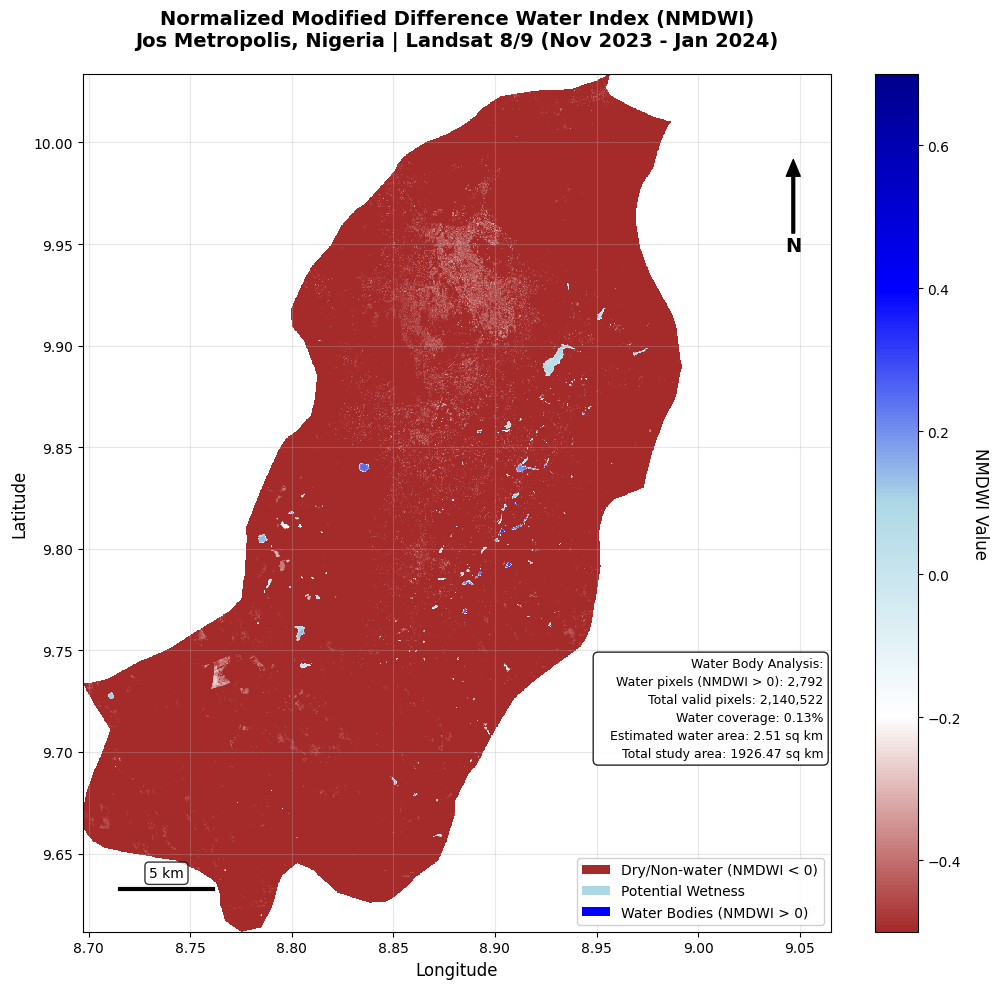

In [43]:
# =============================================================================
# STATIC VISUALIZATION WITH MATPLOTLIB
# =============================================================================

print("📊 Creating static visualization...")

try:
    # Read the mosaicked raster
    with rasterio.open('Output/final_nmdwi_mosaic.tif') as src:
        nmdwi_data = src.read(1)
        transform = src.transform
        crs = src.crs

        # Get bounds
        left, bottom, right, top = src.bounds

    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Create custom colormap
    colors = ['#A52A2A', '#FFFFFF', '#ADD8E6', '#0000FF', '#00008B']
    cmap = mcolors.LinearSegmentedColormap.from_list('nmdwi_cmap', colors, N=256)

    # Plot NMDWI
    im = ax.imshow(nmdwi_data,
                   extent=[left, right, bottom, top],
                   cmap=cmap,
                   vmin=-0.5,
                   vmax=0.7,
                   interpolation='nearest')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('NMDWI Value', rotation=270, labelpad=20, fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    # Set title and labels
    ax.set_title('Normalized Modified Difference Water Index (NMDWI)\nJos Metropolis, Nigeria | Landsat 8/9 (Nov 2023 - Jan 2024)',
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude', fontsize=12)

    # Add grid
    ax.grid(True, alpha=0.3)

    # -------------------------------------------------------------------------
    # Dynamic scale bar
    # -------------------------------------------------------------------------
    def add_scalebar(ax, length_km=None, location=(0.05, 0.05), linewidth=3):
        map_width_m = (right - left) * 111320 * np.cos(np.deg2rad((top + bottom) / 2))
        if length_km is None:
            target_length = map_width_m / 10 / 1000
            possible_lengths = np.array([0.5, 1, 2, 5, 10, 20, 50])
            length_km = possible_lengths[np.argmin(abs(possible_lengths - target_length))]
        length_m = length_km * 1000
        x_start = left + (right - left) * location[0]
        y_start = bottom + (top - bottom) * location[1]
        x_end = x_start + (length_m / (111320 * np.cos(np.deg2rad((top + bottom) / 2))))
        ax.plot([x_start, x_end], [y_start, y_start], color='black', linewidth=linewidth)
        ax.text((x_start + x_end)/2, y_start + (top - bottom)*0.01, f'{int(length_km)} km',
                ha='center', va='bottom', fontsize=10, color='black',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    add_scalebar(ax)

    # -------------------------------------------------------------------------
    # Add north arrow (Top right)
    # -------------------------------------------------------------------------
    ax.annotate('N',
                xy=(0.95, 0.90), xytext=(0.95, 0.80),
                arrowprops=dict(facecolor='black', width=2, headwidth=10),
                ha='center', va='center',
                fontsize=14, fontweight='bold',
                xycoords=ax.transAxes, textcoords=ax.transAxes)

    # -------------------------------------------------------------------------
    # Legend (bottom right)
    # -------------------------------------------------------------------------
    legend_elements = [
        Patch(facecolor='#A52A2A', label='Dry/Non-water (NMDWI < 0)'),
        Patch(facecolor='#ADD8E6', label='Potential Wetness'),
        Patch(facecolor='#0000FF', label='Water Bodies (NMDWI > 0)')
    ]

    legend = ax.legend(handles=legend_elements, loc='lower right',
                       bbox_to_anchor=(1, 0), framealpha=0.9)

    # -------------------------------------------------------------------------
    # Water Body Statistics Table (above legend)
    # -------------------------------------------------------------------------

    stats_text = (
        " Water Body Analysis:\n"
        "   Water pixels (NMDWI > 0): 2,792\n"
        "   Total valid pixels: 2,140,522\n"
        "   Water coverage: 0.13%\n"
        "   Estimated water area: 2.51 sq km\n"
        "   Total study area: 1926.47 sq km"
    )

    # Place table just above the legend
    ax.text(0.99, 0.20, stats_text,
            transform=ax.transAxes,
            fontsize=9, va='bottom', ha='right',
            linespacing=1.5,
            bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85))

    # -------------------------------------------------------------------------
    # Signature
    # -------------------------------------------------------------------------
    ax.text(0.98, 0.02, 'Ojih Samuel', transform=ax.transAxes,
            fontsize=8, color='gray', alpha=0.7,
            ha='right', va='bottom', style='italic')

    plt.tight_layout()

    # Save plot
    plt.savefig('Output/nmdwi_static_plot.jpg', dpi=300, bbox_inches='tight', facecolor='white')
    print("✅ Static plot saved: Output/nmdwi_static_plot.jpg")

    # Display plot
    plt.show()

except Exception as e:
    print(f"❌ Error in static visualization: {e}")





In [35]:
# =============================================================================
# DATA ANALYSIS AND SUMMARY
# =============================================================================

print("\n" + "="*60)
print("📈 DATA ANALYSIS SUMMARY")
print("="*60)

try:
    # Basic statistics
    with rasterio.open('Output/final_nmdwi_mosaic.tif') as src:
        data = src.read(1)
        data_clean = data[~np.isnan(data)]  # Remove NaN values

    print(f"📊 NMDWI Statistics:")
    print(f"   Minimum: {np.nanmin(data):.3f}")
    print(f"   Maximum: {np.nanmax(data):.3f}")
    print(f"   Mean:    {np.nanmean(data):.3f}")
    print(f"   Median:  {np.nanmedian(data):.3f}")
    print(f"   Std Dev: {np.nanstd(data):.3f}")

    # Water body detection (NMDWI > 0 indicates water)
    water_pixels = np.sum(data_clean > 0)
    total_pixels = len(data_clean)
    water_percentage = (water_pixels / total_pixels) * 100

    print(f"\n💧 Water Body Analysis:")
    print(f"   Water pixels (NMDWI > 0): {water_pixels:,}")
    print(f"   Total valid pixels: {total_pixels:,}")
    print(f"   Water coverage: {water_percentage:.2f}%")

    # Area calculation (approximate)
    pixel_area_sqkm = (30 * 30) / 1e6  # Landsat pixel area in sq km (30m resolution)
    total_area_sqkm = total_pixels * pixel_area_sqkm
    water_area_sqkm = water_pixels * pixel_area_sqkm

    print(f"   Estimated water area: {water_area_sqkm:.2f} sq km")
    print(f"   Total study area: {total_area_sqkm:.2f} sq km")

except Exception as e:
    print(f"❌ Error in data analysis: {e}")


📈 DATA ANALYSIS SUMMARY
📊 NMDWI Statistics:
   Minimum: -inf
   Maximum: 0.385
   Mean:    -inf
   Median:  -inf
   Std Dev: nan

💧 Water Body Analysis:
   Water pixels (NMDWI > 0): 2,792
   Total valid pixels: 2,140,522
   Water coverage: 0.13%
   Estimated water area: 2.51 sq km
   Total study area: 1926.47 sq km


In [36]:
# =============================================================================
# FILE MANAGEMENT AND DOWNLOAD LINKS
# =============================================================================

print("\n" + "="*60)
print("📁 OUTPUT FILES SUMMARY")
print("="*60)

# List all output files
def list_files(directory, pattern="*"):
    files = []
    for root, dirs, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(os.path.join(root, filename))
    return files

import fnmatch

output_files = []
for directory in output_dirs:
    if os.path.exists(directory):
        files = list_files(directory, "*.tif") + list_files(directory, "*.shp") + list_files(directory, "*.jpg")
        output_files.extend(files)

if output_files:
    print("Generated output files:")
    for file in output_files:
        file_size = os.path.getsize(file) / (1024 * 1024)  # Size in MB
        print(f"   📄 {file} ({file_size:.2f} MB)")
else:
    print("No output files found.")

print("\n" + "="*60)
print("✅ PROCESSING COMPLETED SUCCESSFULLY!")
print("="*60)

print("\n📋 Next steps:")
print("1. Check the interactive map above for visual inspection")
print("2. Download output files using Colab file browser (left sidebar)")
print("3. The NMDWI plot is saved as 'Output/nmdwi_static_plot.jpg'")
print("4. Mosaicked raster: 'Output/final_nmdwi_mosaic.tif'")
print("5. AOI shapefile: 'output_folder/jos_metropolis.shp'")

# Create a simple download cell for convenience
print("\n⬇️ To download all output files, run this in a new cell:")
print("""
from google.colab import files
import zipfile
import os

# Create zip file of all outputs
with zipfile.ZipFile('jos_metropolis_outputs.zip', 'w') as zipf:
    for root, dirs, files in os.walk('.'):
        for file in files:
            if any(x in root for x in ['Output', 'output_folder', 'gee_nmdwi_tiles']):
                if file.endswith(('.tif', '.shp', '.shx', '.dbf', '.prj', '.jpg')):
                    zipf.write(os.path.join(root, file))

# Download the zip file
files.download('jos_metropolis_outputs.zip')
""")


📁 OUTPUT FILES SUMMARY
Generated output files:
   📄 gee_nmdwi_tiles/nmdwi_jos_05.tif (0.33 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_13.tif (0.27 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_06.tif (0.34 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_02.tif (0.29 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_01.tif (0.22 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_14.tif (0.25 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_11.tif (0.00 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_04.tif (0.11 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_09.tif (0.36 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_03.tif (0.15 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_07.tif (0.11 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_10.tif (0.31 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_08.tif (0.21 MB)
   📄 gee_nmdwi_tiles/nmdwi_jos_12.tif (0.06 MB)
   📄 output_folder/nmdwi_full.tif (3.88 MB)
   📄 output_folder/jos_metropolis.shp (0.00 MB)
   📄 Output/final_nmdwi_mosaic.tif (8.17 MB)
   📄 Output/nmdwi_static_plot.jpg (0.48 MB)

✅ PROCESSING COMPLETED SUCCESSFULLY!

📋 Next steps:
1. Check the interactive map above for visual 